# One Pixel Attack Tutorial

![](images/pred2.png "All it takes is one pixel")

## Imports

In [1]:
# Python Libraries
%matplotlib inline
import numpy as np
import pandas as pd
from keras.datasets import cifar10
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import differential_evolution
from scipy.stats import truncnorm
from IPython.display import clear_output

# Custom Networks
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet

# Helper functions
from helper import plot_image, plot_images, evaluate_models, visualize_attack, attack_stats

matplotlib.style.use('ggplot')

/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Dataset

Load the Cifar10 dataset and all necessary metadata. Keras will need to download the dataset if it is not cached locally already.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

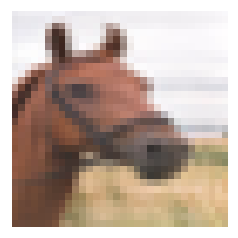

In [4]:
image = 99
plot_image(x_test[image])

## Image Perturbation

In [5]:
def perturb_image(x, img):
    img = np.copy(img)
    pixels = np.split(x.astype(int), len(x) // 5)
    for pixel in pixels:
        x_pos, y_pos, *rgb = pixel
        img[x_pos, y_pos] = rgb
    return img

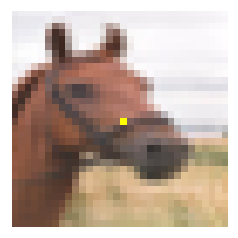

In [6]:
image = 99
pixel = np.array([16, 16, 255, 255, 0])
image_perturbed = perturb_image(pixel, x_test[image])

plot_image(image_perturbed)

## Load Models

Load various pretrained Neural Network models in the `networks/models` directory. There are more networks available, but must be trained before testing them here.

In [7]:
# Available pretrained models
lecun_net = LecunNet()
pure_cnn = PureCnn()
net_in_net = NetworkInNetwork()
resnet = ResNet()
densenet = DenseNet()
wide_resnet = WideResNet()

models = [lecun_net, pure_cnn, net_in_net, resnet]

# If your machine can handle it, uncomment for all available models
# models = [lecun_net, pure_cnn, net_in_net, resnet, densenet, wide_resnet]

Successfully loaded lecun_net
Successfully loaded pure_cnn
Successfully loaded net_in_net
Successfully loaded resnet
Successfully loaded densenet
Successfully loaded wide_resnet


### Calculate Model Accuracies

In [8]:
network_stats, correct_imgs = evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lecun_net
Evaluating pure_cnn
Evaluating net_in_net
Evaluating resnet


,name,accuracy,param_count
0,lecun_net,0.7488,62006
1,pure_cnn,0.8877,1369738
2,net_in_net,0.9074,972658
3,resnet,0.9231,470218


### Prediction Function

In [9]:
def predict_class(x, img, target_class, model, minimize=True):
    img_perturbed = perturb_image(x, img)
    prediction = model.predict_one(img_perturbed)[target_class]
    return prediction if minimize else 1 - prediction

Confidence in true class frog is 0.99999976


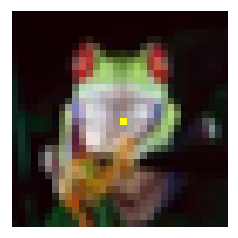

In [10]:
image = 102
pixel = np.array([16, 16, 255, 255, 0])

true_class = y_test[image,0]
model = resnet
confidence = predict_class(pixel, x_test[image], true_class, model)

print('Confidence in true class', class_names[true_class], 'is', confidence)
plot_image(perturb_image(pixel, x_test[image]))

## The Attack

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to minimize the probability of the correct classification category and maximize the sum of the probabilities of all other categories.

### Targeted vs. Untargeted Attacks

### Success Criterion

In [11]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    attack_image = perturb_image(x, x_test[img])
    confidence = model.predict_one(attack_image)
    predicted_class = np.argmax(confidence)
    if (verbose):
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    else:
        return None

Confidence: 0.9999976
Attack success: False


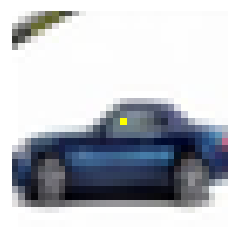

In [12]:
image = 105
pixel = np.array([16, 16, 255, 255, 0])
model = resnet
success = attack_success(pixel, image, y_test[image,0], model, verbose=True)

print('Attack success:', success == True)
plot_image(perturb_image(pixel, x_test[image]))

### Attack Function

In [13]:
def attack(img, model, target=None, pixel_count=1, 
           maxiter=30, popsize=20, verbose=False):
    
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img][0]
    
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Format the predict/callback functions for the differential evolution algorithm
    predict_fn = lambda x: predict_class(
        x, x_test[img], target_class, model, target is None)
    callback_fn = lambda x, convergence: attack_success(
        x, img, target_class, model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popsize,
        recombination=1, atol=-1, callback=callback_fn)

    attack_image = perturb_image(attack_result.x, x_test[img])
    prior_probs = model.predict_one(x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_image]

#### Untargeted Attack

Confidence: 0.9731295
Confidence: 0.7859155
Confidence: 0.7859155
Confidence: 0.7859155
Confidence: 0.62636065
Confidence: 0.4261915


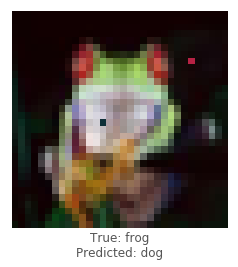

In [14]:
image = 102
pixels = 2
model = resnet
_ = attack(image, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

Attacking with target automobile
Confidence: 0.02378367
Confidence: 0.02378367
Confidence: 0.02378367
Confidence: 0.026306313
Confidence: 0.026306313
Confidence: 0.0513022
Confidence: 0.0513022
Confidence: 0.06527986
Confidence: 0.06527986
Confidence: 0.07052445
Confidence: 0.07052445
Confidence: 0.07886145
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.4104339
Confidence: 0.5042228


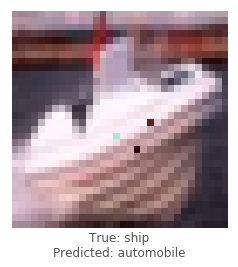

In [15]:
image = 108
target_class = 1 # Integer in range 0-9
pixels = 3
model = lecun_net
print('Attacking with target', class_names[target_class])
_ = attack(image, model, target_class, pixel_count=pixels, popsize=50, maxiter=40, verbose=True)

### Collect Results

In [16]:
def attack_all(models, samples=100, pixels=(1,2,3), targeted=False, verbose=False):
    results = []
    for model in models:
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples)
        for pixel_count in pixels:
            for i,img in enumerate(img_samples):
                print(model.name, '- image', img, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if (targeted):
                        print('Attacking with target', class_names[target])
                        if (target == y_test[img][0]):
                            continue
                    result = attack(img, model, target, pixel_count, 
                                    popsize=(30 // pixel_count), verbose=verbose)
                    results.append(result)
    return results

In [ ]:
untargeted = attack_all(models, samples=100, targeted=False)

In [ ]:
targeted = attack_all(models, samples=10, pixels=[1], targeted=True)

### Attack Statistics

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'attack_image']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [ ]:
attack_stats(untargeted_results)

#### Targeted

In [ ]:
attack_stats(targeted_results)

### Show some successful attacks

Plot 9 random misclassified images

In [ ]:
visualize_attack(untargeted_results, class_names)

In [ ]:
visualize_attack(targeted_results, class_names)

## Credits
 - Base code taken from https://github.com/09rohanchopra/cifar10
 - https://arxiv.org/pdf/1412.6806.pdf
 - https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
 - https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
 - http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
 - https://parneetk.github.io/blog/cnn-cifar10/
 - https://github.com/dnlcrl/deep-residual-networks-pyfunt/blob/master/docs/CIFAR-10%20Experiments.ipynb